In [1]:
import pandas as pd

df = pd.read_csv('MaunaLoaDailyTemps.csv')
df.head()

,DATE,MinTemp,MaxTemp,AvgTemp,Sunrise,Sunset
0,1/1/2014,33.0,46.0,40.0,657,1756
1,1/2/2014,35.0,50.0,43.0,657,1756
2,1/3/2014,36.0,45.0,41.0,657,1757
3,1/4/2014,32.0,41.0,37.0,658,1757
4,1/5/2014,24.0,38.0,31.0,658,1758


Epoch 1/50
39/39 [==============================] - 3s 19ms/step - loss: 0.5247 - accuracy: 0.0016
Epoch 2/50
39/39 [==============================] - 1s 19ms/step - loss: 0.3105 - accuracy: 8.1433e-04
Epoch 3/50
39/39 [==============================] - 1s 19ms/step - loss: 0.2573 - accuracy: 0.0016
Epoch 4/50
39/39 [==============================] - 1s 19ms/step - loss: 0.2273 - accuracy: 0.0016
Epoch 5/50
39/39 [==============================] - 1s 19ms/step - loss: 0.1783 - accuracy: 0.0016
Epoch 6/50
39/39 [==============================] - 1s 19ms/step - loss: 0.1495 - accuracy: 0.0016
Epoch 7/50
39/39 [==============================] - 1s 19ms/step - loss: 0.1472 - accuracy: 0.0016
Epoch 8/50
39/39 [==============================] - 1s 19ms/step - loss: 0.1202 - accuracy: 8.1433e-04
Epoch 9/50
39/39 [==============================] - 1s 19ms/step - loss: 0.1011 - accuracy: 0.0000e+00
Epoch 10/50
39/39 [==============================] - 1s 19ms/step - loss: 0.0872 - accuracy: 0.00

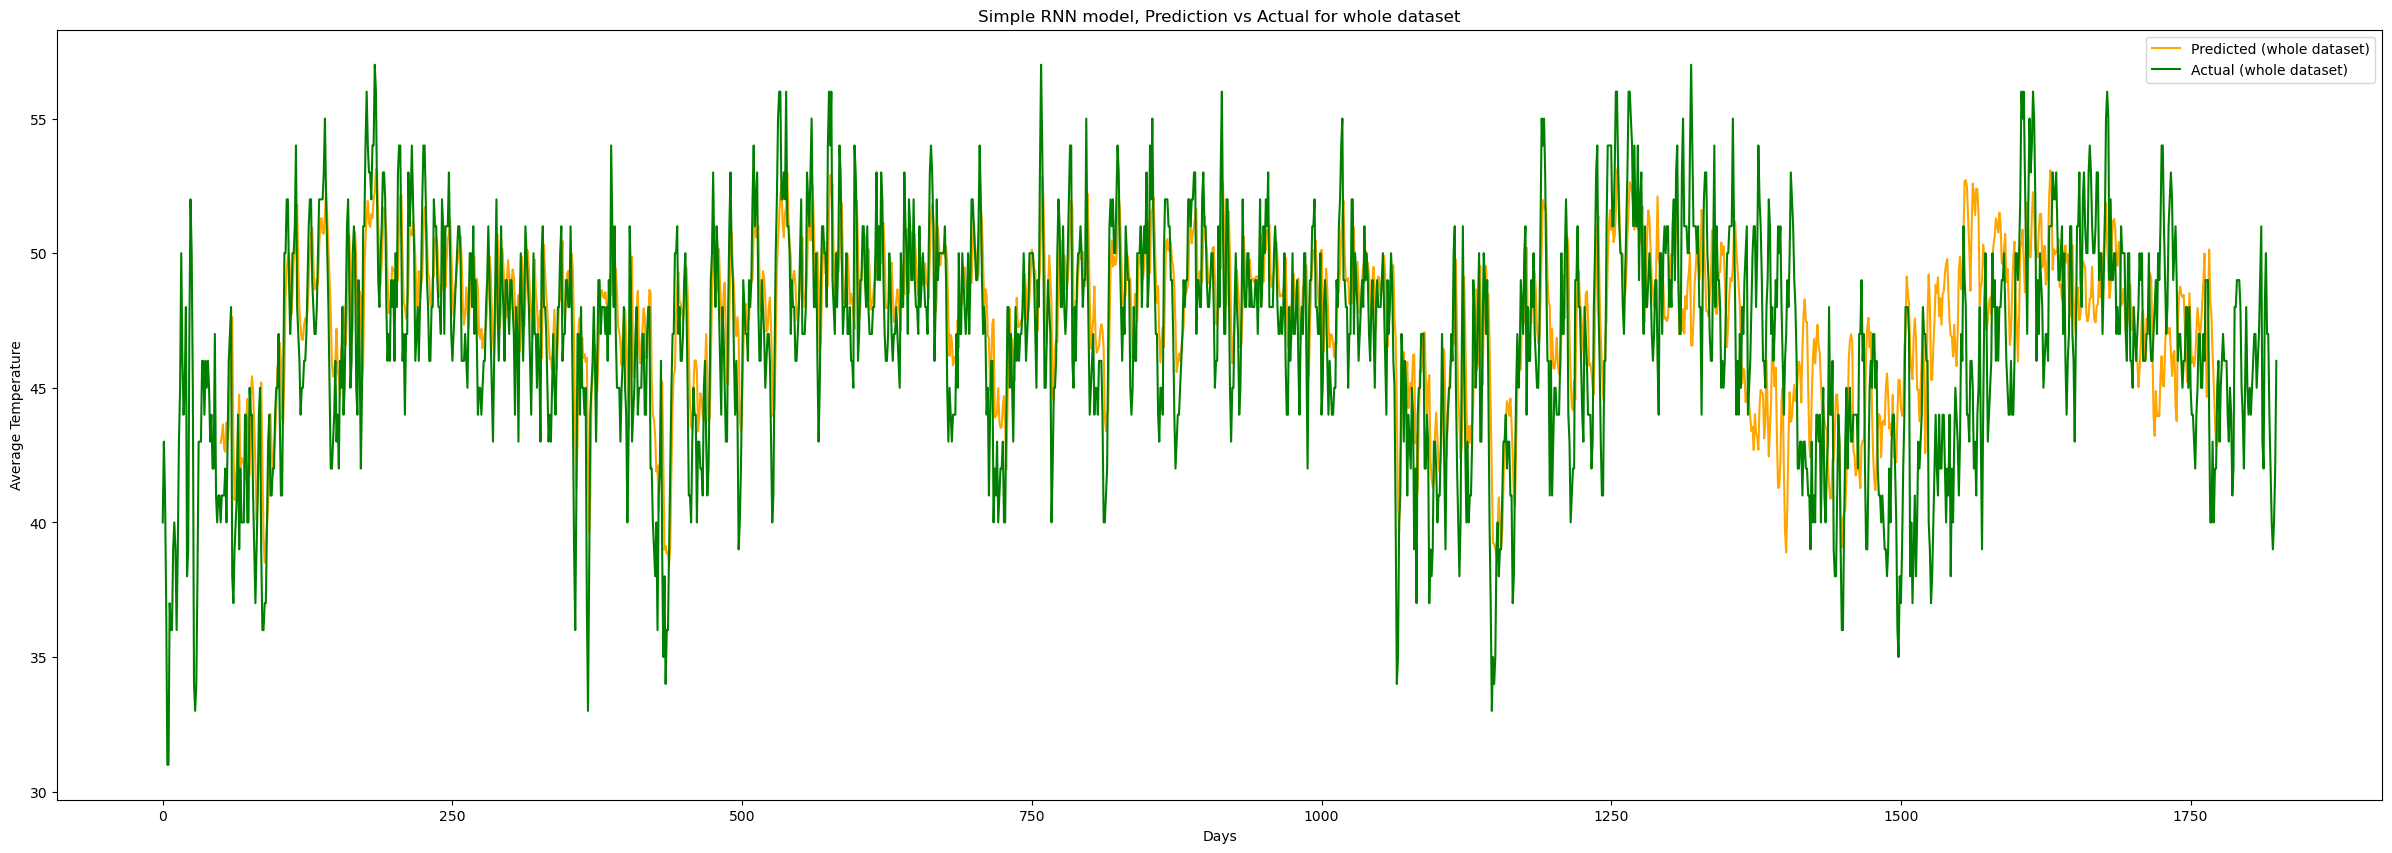

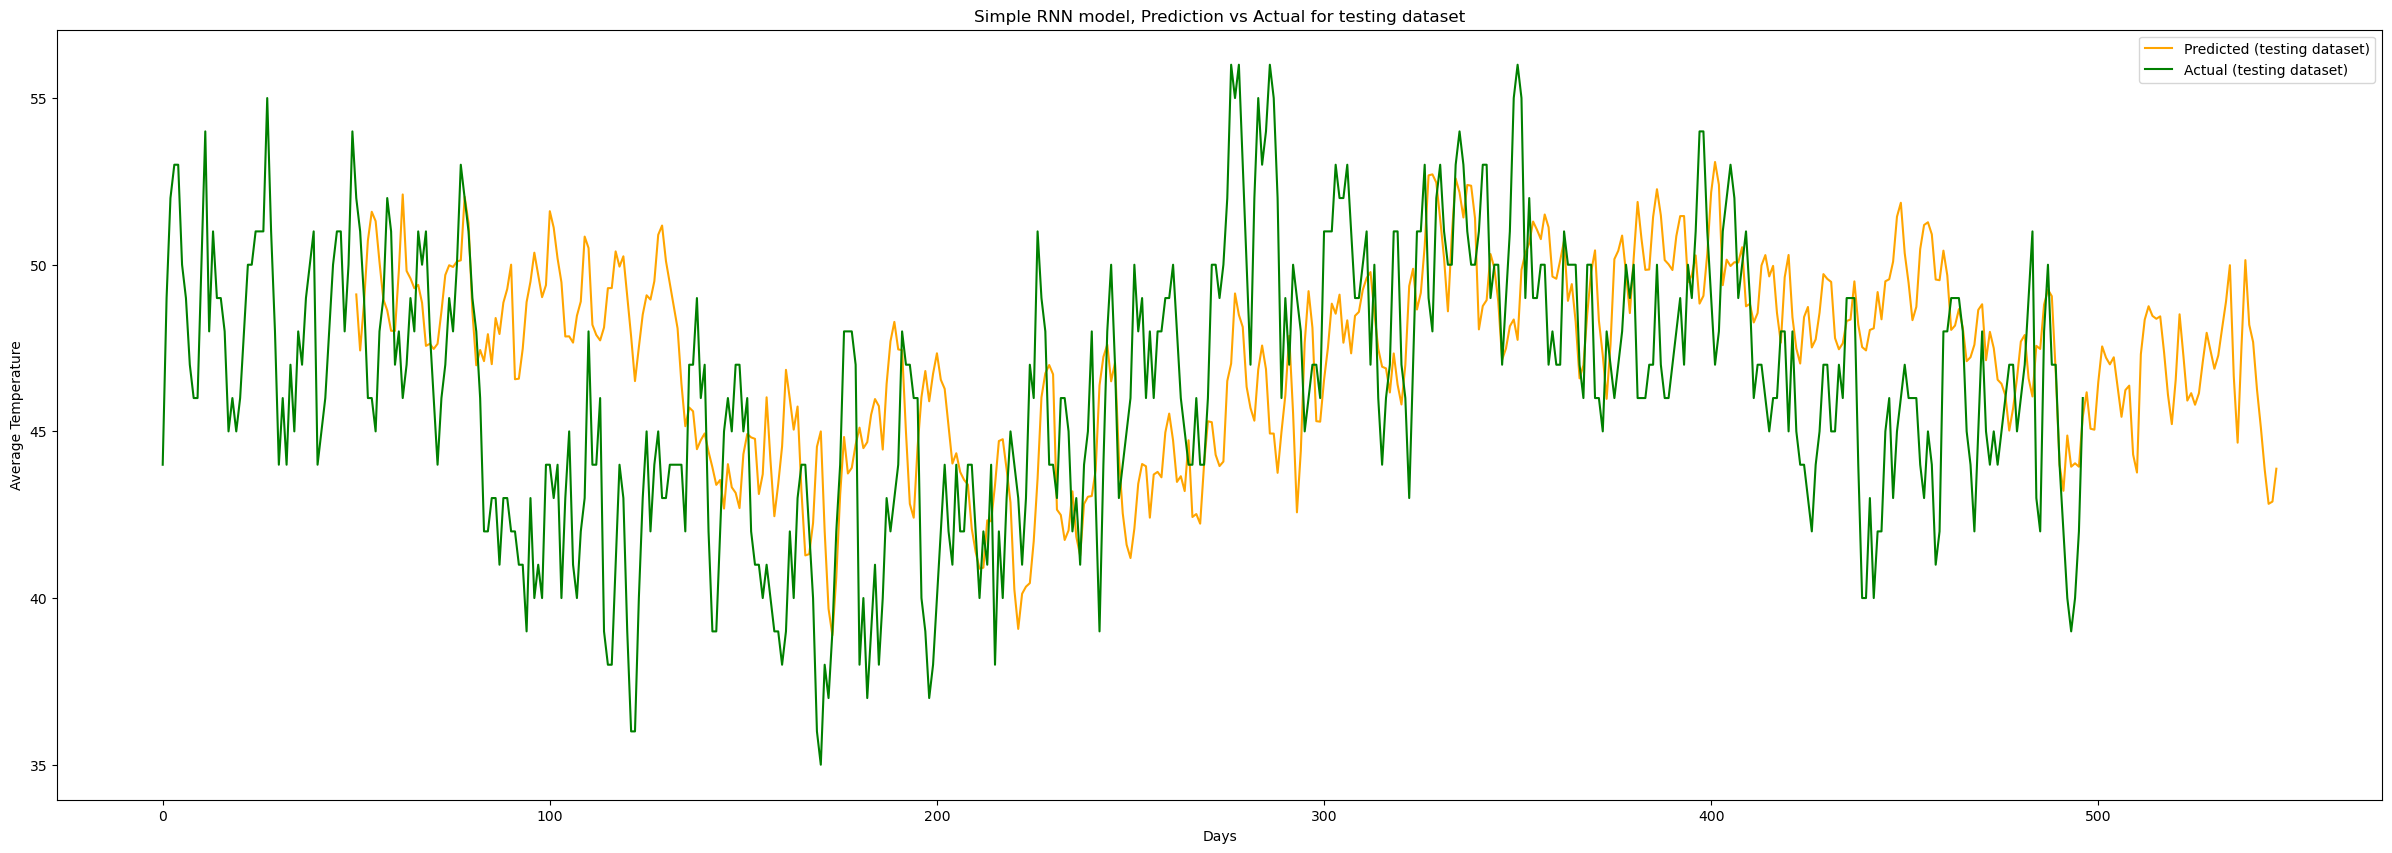

Mean: 46.818082191780825
Correlation between Actual and Predicted Values: 0.8156385766251842
39/39 [==============================] - 0s 6ms/step
RMSE on Training Set: 0.10078359481567847
RMSE on Test Set: 2.5803851148102757
39/39 [==============================] - 0s 6ms/step
R2 Score on Training Set: 0.5686118098381783
R2 Score on Test Set: 0.5984118941322423


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Load data
data = pd.read_csv("MaunaLoaDailyTemps.csv")

# Check for NaN or infinite values in the data and handle them
if data.isnull().values.any() or np.isinf(data.values).any():
    data = data.fillna(method='ffill')

# Split dataset
length_train = round(len(data) * 0.7)
train_data = data[:length_train]['AvgTemp'] 
validation_data = data[length_train:]['AvgTemp']

# Normalize
scaler = MinMaxScaler(feature_range = (0,1))
dataset_train_scaled = scaler.fit_transform(train_data.values.reshape(-1,1))

# Create X_train and y_train
time_step = 50
X_train = np.array([dataset_train_scaled[i-time_step:i,0] for i in range(time_step, length_train)])
y_train = np.array([dataset_train_scaled[i,0] for i in range(time_step, length_train)])

# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

# Create RNN model
regressor = Sequential()
regressor.add(SimpleRNN(units = 50,activation = "tanh", return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

# Compile and fit RNN
regressor.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

# Predictions
y_pred = scaler.inverse_transform(regressor.predict(X_train))

# Validation data
scaled_dataset_validation =  scaler.transform(validation_data.values.reshape(-1,1))

# Create X_test and y_test
X_test = np.array([scaled_dataset_validation[i-time_step:i,0] for i in range(time_step, len(scaled_dataset_validation))])
y_test = np.array([scaled_dataset_validation[i,0] for i in range(time_step, len(scaled_dataset_validation))])

# Reshape
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

# Predictions with X_test data
y_pred_of_test = scaler.inverse_transform(regressor.predict(X_test))

# Visualisation
plt.figure(figsize = (30,10))
plt.plot(np.concatenate([np.full((time_step,1), np.nan), y_pred, y_pred_of_test]), label = "Predicted (whole dataset)", c = "orange")
plt.plot(data['AvgTemp'].values, label = "Actual (whole dataset)", c = "g")
plt.xlabel("Days")
plt.ylabel("Average Temperature")
plt.title("Simple RNN model, Prediction vs Actual for whole dataset")
plt.legend()
plt.show()

plt.figure(figsize = (30,10))
plt.plot(np.concatenate([np.full((time_step,1), np.nan), y_pred_of_test]), label = "Predicted (testing dataset)", c = "orange")
plt.plot(data['AvgTemp'].values[-len(y_pred_of_test):], label = "Actual (testing dataset)", c = "g")
plt.xlabel("Days")
plt.ylabel("Average Temperature")
plt.title("Simple RNN model, Prediction vs Actual for testing dataset")
plt.legend()
plt.show()

# Calculate the mean of the 'AvgTemp' column
mean_temp = data['AvgTemp'].mean()
print(f"Mean: {mean_temp}")

# Calculate the correlation between the actual and predicted values
correlation = np.corrcoef(data['AvgTemp'].values[-len(y_pred_of_test):], y_pred_of_test[:, 0])[0, 1]
print(f"Correlation between Actual and Predicted Values: {correlation}")

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, regressor.predict(X_train)))
rmse_test = np.sqrt(mean_squared_error(data['AvgTemp'].values[-len(y_pred_of_test):], y_pred_of_test))

print(f"RMSE on Training Set: {rmse_train}")
print(f"RMSE on Test Set: {rmse_test}")

# Calculate R2 Score
r2_train = r2_score(y_train, regressor.predict(X_train))
r2_test = r2_score(data['AvgTemp'].values[-len(y_pred_of_test):], y_pred_of_test)

print(f"R2 Score on Training Set: {r2_train}")
print(f"R2 Score on Test Set: {r2_test}")
